# Deep Learning - Comparing the models
### *Facial age recognition - a SML Regression problem*

# 1. References

1. `tf.keras.losses.Poisson`, [offical documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Poisson)
2. Poisson Regression, [link](https://en.wikipedia.org/wiki/Poisson_regression)
3. `tf.keras.losses.MeanSquaredLogarithmicError`, [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredLogarithmicError)

# 2. Initial Treatment

## 2.1. Import Libraries

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, initializers, regularizers, optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import keras_tuner as kt

from sklearn.metrics import mean_squared_error

import os
import time
from pathlib import Path
import pickle

import warnings
warnings.filterwarnings("ignore")

## 2.2. Auxiliary functions

Collection of all user defined functions in this notebook. 

In [ ]:
def plot_compare_models(model_names, model_dict, ylim):
    """
    Plots the training and validation loss curves for multiple models in the same plot for comparison.

    Args:
    --
    - model_names (list): List of model names to be plotted.
    - model_dict (dict): Dictionary containing trained models and their training history.

    Returns:
    --
    - None

    """
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['blue', 'orangered']  # define set of colors
    color_index = 0
    for name in model_names:
        df_hist = pd.DataFrame.from_dict(model_dict[name])
        df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
        ax.plot(df_hist["Epoch"], df_hist['loss'], label=f'{name} training', color=colors[color_index], linestyle='--')
        ax.plot(df_hist["Epoch"], df_hist['val_loss'], label=f'{name} test', color=colors[color_index]) 
        color_index += 1
        ax.legend(loc="best", framealpha=1.0, fontsize=9, title='Legend')
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_title(f"Compare models", fontsize=16)
    ax.grid(True, color="white")
    ax.set_ylim(ylim)
    ax.set_facecolor('gainsboro') 
    plt.xticks(np.arange(1, len(df_hist)+1, 1.0, dtype=int))
    plt.show()


In [ ]:
def scatterplot_predict(y_true, y_pred):
    """
    Creates a scatterplot with y_true on the y-axis and y_pred on the x-axis.

    Args:
    - y_true (array): Array of true labels
    - y_pred (array): Array of predicted labels

    Returns:
    - None
    """
    sns.set_style("darkgrid")
    sns.jointplot(x=y_pred, y=y_true, line_kws={'color': 'orangered'}, kind="reg", height=7)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('True vs. Predicted Labels', y=1.2, fontsize=16)
    plt.show()


In [ ]:
def extract_features(model, dataset):
    """
    Extracts features and labels from a dataset using a given model.

    Args:
    --
        model (models.Model): A Keras model that will be used to extract features.
        dataset (tf.data.Dataset): The dataset to extract features and labels from.

    Returns:
    --
        features (array): the extracted features
        labels (array): the corresponding labels to the features
    """
    # Get the number of samples in the dataset.
    sample_count = getattr(dataset, "samples", None)
    if sample_count is None:
        raise ValueError("Dataset has no attribute 'samples'.")

    # Get the batch size of the dataset.
    batch_size = getattr(dataset, "batch_size", None)
    if batch_size is None:
        raise ValueError("Dataset has no attribute 'batch_size'.")

    # Initialize arrays to store the features and labels.
    features = np.zeros(shape=(sample_count, 1))
    labels = np.zeros(shape=(sample_count))

    # Loop over the dataset in batches and extract features and labels.
    counter = 0
    for inputs_batch, labels_batch in dataset:
        # Calculate the upper bound of the current batch.
        size_upper_bound = (counter + 1) * batch_size
        if batch_size != len(labels_batch):
            size_upper_bound = counter * batch_size + len(labels_batch)

        # Extract features from the current batch.
        features_batch = model.predict(inputs_batch)

        # Store the features and labels in the corresponding arrays.
        features[counter * batch_size : size_upper_bound] = features_batch
        labels[counter * batch_size : size_upper_bound] = labels_batch

        # Increment the counter.
        counter += 1

        # Check if we have processed all samples in the dataset.
        if counter * batch_size >= sample_count:
            break

    return features, labels

## 2.3. Import datasets and models

### 2.3.1. Import datasets

In [ ]:
# Define the path, where the dataset should be saved
vm_path = "/content"
path = "/content/drive/MyDrive/FacialAgeProject/"

data_path = os.path.join(path, 'data')
metadata_path = os.path.join(path, 'metadata')
dataset_path = os.path.join(data_path, "facial_age_dataset_unsplit/")

duplicated_path = os.path.join(metadata_path, 'ahash_duplicated_keys.pkl')
preprocessed_path = os.path.join(data_path, 'facial_age_dataset_preprocessed')

train_path = Path(os.path.join(preprocessed_path, 'train'))
test_path = Path(os.path.join(preprocessed_path, 'test'))

metadata_csv_path = os.path.join(metadata_path, 'images_metadata.csv')
# metadata_csv_path = path + 'metadata/images_metadata.csv'

In [ ]:
# Image dataset with all the files configurations
images_df = pd.read_csv(metadata_csv_path)
images_df = images_df.sample(frac = 1.0).reset_index(drop = True)
images_df.head()

# Train dataset to be used in the generator
train_file_names = pd.Series(list(train_path.glob(r'**/*.png')),name = 'file_names').astype('str')
train_file_names = train_file_names.apply(lambda x : x.split("/")[-1])
train_images_df = images_df[images_df['file_name'].isin(train_file_names)]
train_images_df['file_name'] = '..' + f'{train_path}'+ '/' + train_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + train_images_df['file_name']
# train_images_df['weights'] = train_images_df['age_label'].apply(lambda x : weights_dict[x])

# Test dataset to be used in the generator
test_file_names = pd.Series(list(test_path.glob(r'**/*.png')),name = 'file_names').astype('str')
test_file_names = test_file_names.apply(lambda x : x.split('/')[-1])
test_images_df = images_df[images_df['file_name'].isin(test_file_names)]
test_images_df['file_name'] = '..' + f'{test_path}'+ '/' + test_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + test_images_df['file_name']

print('Train files and dataset lenght (must check) : {} vs {}'.format(len(train_file_names),train_images_df.shape[0]))
print('test files and dataset lenght (must check) : {} vs {}'.format(len(test_file_names),test_images_df.shape[0]))

In [ ]:
# Defining global variables
batch_size = 64
seed = 0
input_shape = (None, 200, 200, 3)
dict_model_history = {}

In [ ]:
# Data generators and parameters.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

generate_params = {
    'target_size' : (200,200),
    'color_mode' : 'rgb',
    'class_mode' : 'raw',
    'batch_size' : batch_size,
    'seed' : seed
}

In [ ]:
# Generators instances and data spliting.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    **generate_params
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    **generate_params
)

Found 7008 validated image filenames.
Found 1752 validated image filenames.


### 2.3.2. Handcrafted models

Import the handcrafted models, created in handcrafted_models.ipynb.

In [ ]:
# Define the paths of the models.
path = "/content/drive/MyDrive/FacialAgeProject/"
handcrafted_lenet_name = "handcrafted_LeNet-V7"
handcrafted_alexnet_name = "handcrafted_AlexNet-V4"

path_handcrafted_lenet_model = os.path.join(path, handcrafted_lenet_name)
path_handcrafted_lenet_history = os.path.join(path, handcrafted_lenet_name, "LeNet-V7-history.pkl")

path_handcrafted_alexnet_model = os.path.join(path, handcrafted_alexnet_name)
path_handcrafted_alexnet_history = os.path.join(path, handcrafted_alexnet_name, "AlexNet-V4-history.pkl")

In [ ]:
# Import the LeNet
handcrafted_lenet = tf.keras.models.load_model(path_handcrafted_lenet_model)
with (open(path_handcrafted_lenet_history, "rb")) as openfile:
    handcrafted_lenet_history = pickle.load(openfile)
    dict_model_history["handcrafted_lenet"] = handcrafted_lenet_history

handcrafted_lenet.summary()
print(f"Import check history: {handcrafted_lenet_history} \n")
print(f"LeNet imported.")

Model: "le_net_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  336       
                                                                 
 conv2d_1 (Conv2D)           multiple                  3488      
                                                                 
 dense (Dense)               multiple                  9600120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

In [ ]:
# Import the AlexNet
handcrafted_alexnet = tf.keras.models.load_model(path_handcrafted_alexnet_model)
with (open(path_handcrafted_alexnet_history, "rb")) as openfile:
    handcrafted_alexnet_history = pickle.load(openfile)
    dict_model_history["handcrafted_alexnet"] = handcrafted_alexnet_history

handcrafted_alexnet.summary()
print(f"Import check history: {handcrafted_alexnet_history}\n")
print(f"AlexNet imported.")

Model: "alex_net_v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_2 (Conv2D)           multiple                  221376    
                                                                 
 conv2d_3 (Conv2D)           multiple                  331968    
                                                                 
 conv2d_4 (Conv2D)           multiple                  221312    
                                                                 
 batch_normalization (BatchN  multiple                 

### 2.3.3. Tuned models

Import the tuned models, created in hypertuned_models.ipynb.

In [ ]:
# Define the path, where the dataset should be saved
path = "/content/drive/MyDrive/FacialAgeProject/"
tuned_lenet_name = "tuned_LeNet-V7"
tuned_alexnet_name = "tuned_AlexNet-V4"

path_tuned_lenet_model = os.path.join(path, tuned_lenet_name)
path_tuned_lenet_history = os.path.join(path, tuned_lenet_name, "LeNet-V7-history.pkl")

path_tuned_alexnet_model = os.path.join(path, tuned_alexnet_name)
path_tuned_alexnet_history = os.path.join(path, tuned_alexnet_name, "AlexNet-V4-history.pkl")

In [ ]:
# Import the LeNet
tuned_lenet = tf.keras.models.load_model(path_tuned_lenet_model)
with (open(path_tuned_lenet_history, "rb")) as openfile:
    tuned_lenet_history = pickle.load(openfile)
    dict_model_history["tuned_lenet"] = tuned_lenet_history

tuned_lenet.summary()
print(f"Import check history: {tuned_lenet_history} \n")
print(f"LeNet imported.")

Model: "le_net_v7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  760       
                                                                 
 conv2d_1 (Conv2D)           multiple                  7530      
                                                                 
 dense (Dense)               multiple                  9000120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

In [ ]:
# Import the AlexNet
tuned_alexnet = tf.keras.models.load_model(path_tuned_alexnet_model)
with (open(path_tuned_alexnet_history, "rb")) as openfile:
    tuned_alexnet_history = pickle.load(openfile)
    dict_model_history["tuned_alexnet"] = tuned_alexnet_history

tuned_alexnet.summary()
print(f"Import check history: {tuned_alexnet_history}\n")
print(f"AlexNet imported.")

Model: "alex_net_v9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  9728      
                                                                 
 conv2d_1 (Conv2D)           multiple                  819456    
                                                                 
 conv2d_2 (Conv2D)           multiple                  1638656   
                                                                 
 conv2d_3 (Conv2D)           multiple                  1433824   
                                                                 
 conv2d_4 (Conv2D)           multiple                  537696    
                                                                 
 batch_normalization (BatchN  multiple                 

### 2.3.4. Pretrained model

Import the pretrained VGG16, created in pretrained_models.ipynb.

In [ ]:
# Define the paths of the models.
path = "/content/drive/MyDrive/FacialAgeProject/"
pretrained_vgg_name = "pretrained_VGG"

path_pretrained_vgg_model = os.path.join(path, pretrained_vgg_name)
path_pretrained_vgg_history = os.path.join(path, pretrained_vgg_name, "VGG-history.pkl")

In [ ]:
# Import the pretrained VGG
pretrained_vgg = tf.keras.models.load_model(path_pretrained_vgg_model, compile=False)
pretrained_vgg.compile(optimizer=optimizers.Adam(learning_rate=0.005),
                        loss = losses.MeanSquaredError(),
                        metrics=[metrics.MeanAbsoluteError(name='MAE'),
                        metrics.MeanAbsolutePercentageError(name='MAPE'),
                        metrics.RootMeanSquaredError(name='RMSE'),
                        metrics.MeanSquaredLogarithmicError(name='MSLE')])

with (open(path_pretrained_vgg_history, "rb")) as openfile:
    pretrained_vgg_history = pickle.load(openfile)
    dict_model_history["pretrained_vgg"] = pretrained_vgg_history

pretrained_vgg.summary()
print(f"Import check history: {pretrained_vgg_history} \n")
print(f"LeNet imported.")

Model: "pre_trained_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_9 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense_52 (Dense)            multiple                  147488    
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_53 (Dense)            multiple                  33        
                                                                 
 flatten_21 (Flatten)        multiple                  0         
                                                                 
Total params: 147,521
Trainable params: 147,521
Non-trainable params: 0
______________________________________________

# 3. Comparsion of models

Next, we will generate visualizations of the optimized and manually created LeNet and AlexNet models, as well as the pre-trained VGG model, and make a comparative analysis among them.

## 3.1. LeNet

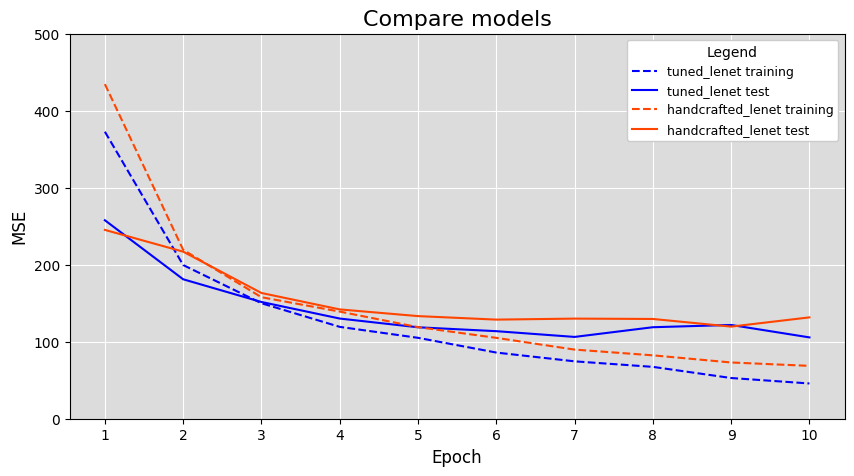

In [ ]:
plot_compare_models(model_dict=dict_model_history,
                    model_names=["tuned_lenet", "handcrafted_lenet"],
                    ylim=[0,500])

Despite hypertuning the LeNet-V7 model, the increase in performance was only marginal, and overfitting is still seen in the training data after just 5 epochs.

## 3.2. AlexNet

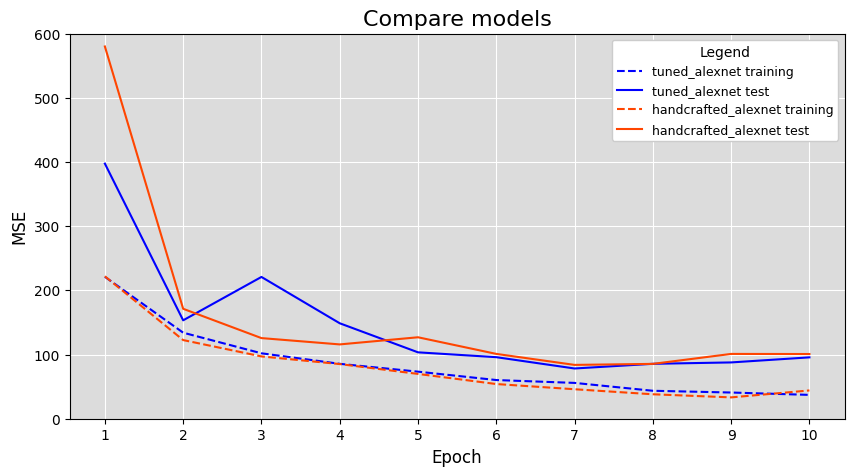

In [ ]:
plot_compare_models(model_dict=dict_model_history,
                    model_names=["tuned_alexnet", "handcrafted_alexnet"],
                    ylim=[0,600])

The manual tuning of the handcrafted AlexNet-V4 model resulted in only a slight improvement in the training loss, and the test loss remained unchanged after epoch 6. Therefore, we can conclude that our manual tuning was effective, and further hypertuning of the model is unlikely to result in any significant improvements.

## 3.3. VGG16

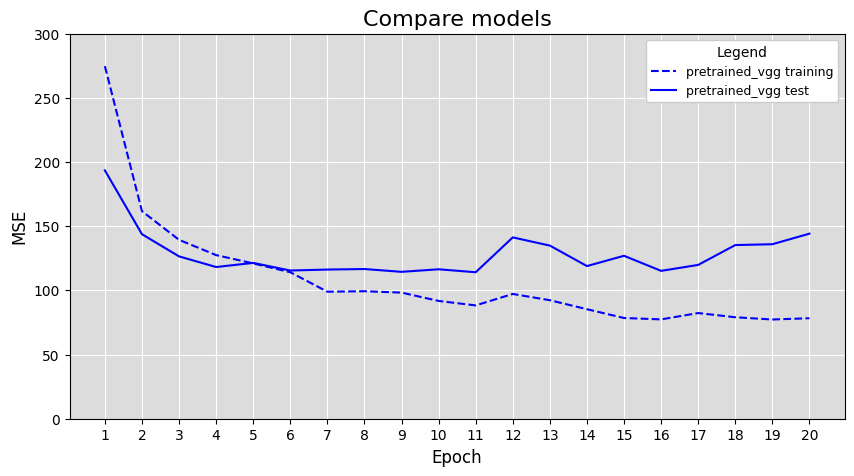

In [ ]:
plot_compare_models(model_dict=dict_model_history,
                    model_names=["pretrained_vgg"],
                    ylim=[0,300])

Despite training the model for 10 additional epochs and fine-tuning the last three convolutional layers of VGG16, our attempts to improve the training loss using the pre-trained VGG16 from the Keras library were unsuccessful. Our initial hope was to achieve better results with this approach, but unfortunately, it did not yield any improvements.

## 3.4. Conclusion

In summary, we see that our manually designed model, AlexNet-V4, achieved the most favorable outcomes on both the training and test datasets for our facial age prediction task.

# 4. Anaylsis of predicted labels

We use our best model, the tuned AlexNet-V4, to make predictions on the test dataset. We then analyze these predictions using scatter and histogram plots. To obtain a more detailed understanding of the results, we first examine all predictions together and then divided the dataset into four age groups:

- Age group 1: individuals under 20 years old
- Age group 2: individuals aged 20 to 40 years old
- Age group 3: individuals aged 40 to 60 years old
- Age group 4: individuals over 60 years old

This approach allowed us to determine the accuracy of our predictions for each age group separately.

In [ ]:
best_model = handcrafted_alexnet

# Extract the features and test labels
y_pred, y_true = extract_features(best_model, test_images)

1/1 [==============================] - 0s 25ms/step


In [ ]:
# Create a dataframe with the labels and calculate squard error.
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred.flatten()})
df["SE"] = (df.y_true - df.y_pred)**2

display(df)

,y_true,y_pred,SE
0,35.0,28.935736,36.775301
1,50.0,28.740120,451.982500
2,1.0,1.380457,0.144748
3,29.0,47.259251,333.400234
4,56.0,52.586784,11.650041
...,...,...,...
1747,4.0,6.925342,8.557624
1748,42.0,51.374298,87.877465
1749,46.0,51.085468,25.861988
1750,54.0,58.419392,19.531022


## 4.1. Plotting the data

### 4.1.1. All ages

MSE: 98.5


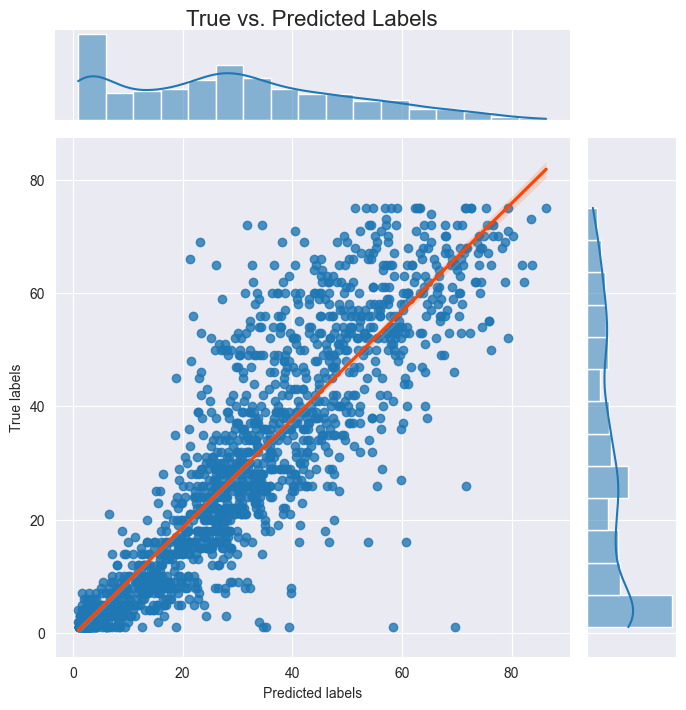

In [ ]:
mse = mean_squared_error(df['y_true'], df['y_pred'])
print('MSE:', np.round(mse,1))

scatterplot_predict(df.y_true, df.y_pred)

### 4.1.2 Age group 1

MSE: 67.2


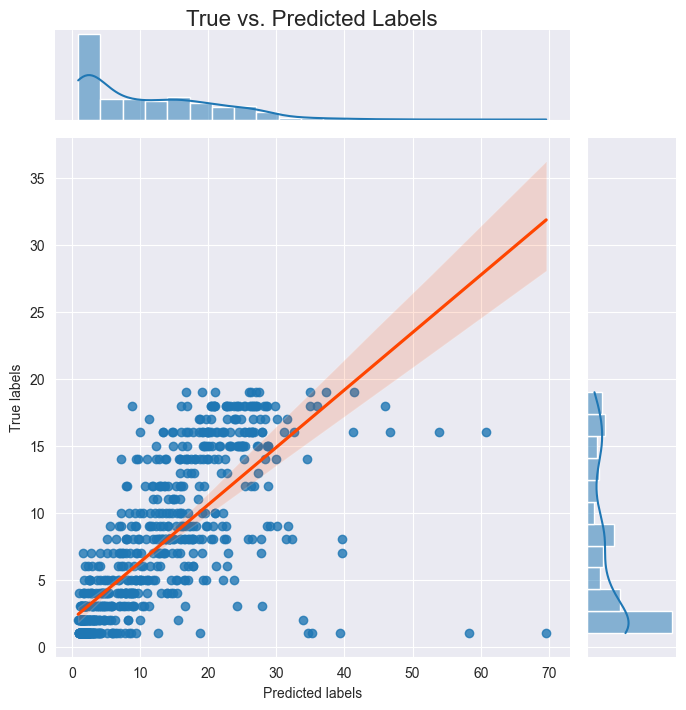

In [ ]:
df_filtered = df[(df["y_true"] < 20)]

mse = mean_squared_error(df_filtered['y_true'], df_filtered['y_pred'])
print('MSE:', np.round(mse,1))
scatterplot_predict(df_filtered["y_true"], df_filtered["y_pred"])

### 4.1.3 Age group 2

MSE: 75.3


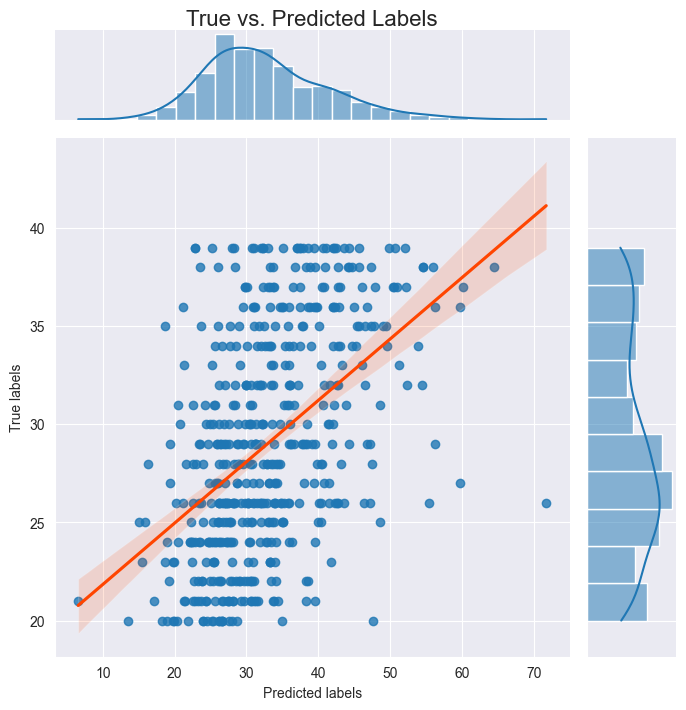

In [ ]:
df_filtered = df[(df["y_true"] >= 20) & (df["y_true"] < 40)]

mse = mean_squared_error(df_filtered['y_true'], df_filtered['y_pred'])
print('MSE:', np.round(mse,1))
scatterplot_predict(df_filtered["y_true"], df_filtered["y_pred"])

### 4.1.4. Age group 3

MSE: 143.4


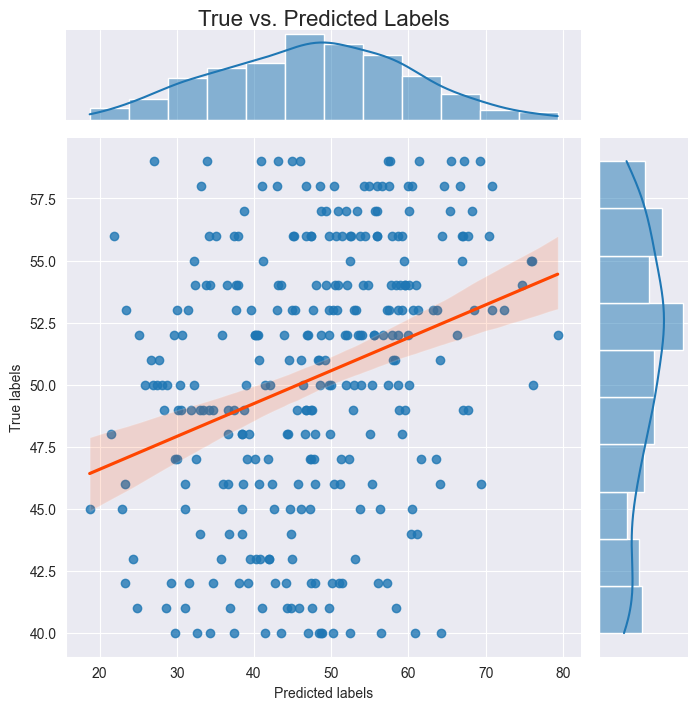

In [ ]:
df_filtered = df[(df["y_true"] >= 40) & (df["y_true"] < 60)]

mse = mean_squared_error(df_filtered['y_true'], df_filtered['y_pred'])
print('MSE:', np.round(mse,1))
scatterplot_predict(df_filtered["y_true"], df_filtered["y_pred"])

### 4.1.5. Age group 4

MSE: 216.1


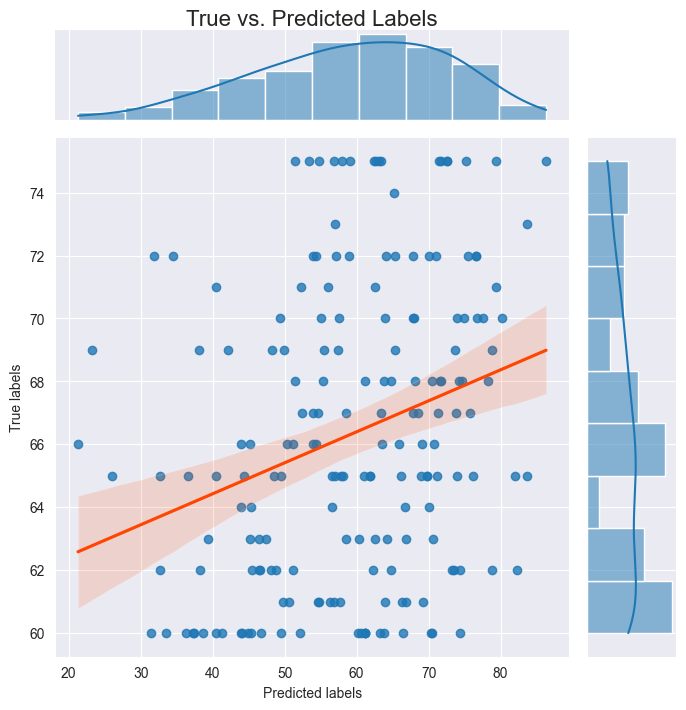

In [ ]:
df_filtered = df[(df["y_true"] >= 60)]

mse = mean_squared_error(df_filtered['y_true'], df_filtered['y_pred'])
print('MSE:', np.round(mse,1))
scatterplot_predict(df_filtered["y_true"], df_filtered["y_pred"])

## 4.2. Observations

When we compare the predictions with the true labels of the test dataset, we observe an average deviation of ~10 years, as shown by the MSE of 98.5. It is apparent that our predictions are more accurate for younger individuals compared to older ones, as evidenced by the increasing MSE values across the presented age groups (ranging from 67.2 for individuals younger than 20 years to 216.1 for individuals older than 60 years).

# 5. Conclusion on Facial Age Recognition Project

To summarize, our model's training was heavily influenced by the imbalanced distribution of images across age groups in the original dataset, leading to a bias towards images of younger individuals. Due to time and computational limitations, we could not try out more complex architectures and other techniques to improve the model's performance and overcome this challenge. 
However, if we would have more time, we would apply the following solutions to reach a more satisfying result:

The steps are arranged according to the time required and level of difficulty:
- As a next step, the simplest solution could be to divide the output into age buckets, as we did in our analysis of the predicted labels. This would allow for a higher deviation in the predicted age, which is acceptable given that even humans sometimes struggle to accurately predict another person's age.
- We could invest more time in handling outliers, which in this context refers to incorrectly classified humans in age groups or pictures that do not feature a face. However, it must to be proven, that these outliers have a high influence on our model training.
- Additionally, we could increase the number of epochs for the best models. Sadly this was not possible due to time and performance constraints. Doing so could lead to improved predictions.
- More technically, one way to address this problem is to try different loss functions. Given that the problem is a regression problem with a dataset with people’s ages we have a discrete distribution of positive values, taking this into account, we could try to use the loss Poisson [1] to model it as a Poisson regression [2]. Another option could be to try the loss Mean Squared Logarithmic Error [3] which penalizes predictions that has greater deviations from the true values.  
- Another option would be to increase the complexity of our models or experiment with different models such as MobileNet or ResNet.
- Finally, the most effective but also most challenging solution would be to expand the dataset for older age groups to create a more balanced dataset.